# 1. Motivation/Business Problem

My client is an entrepreneur that has created and owns a restaurant chain whose product is a unique fusion of Greek and Lebanese cuisines.  The franchise was established 5 years ago in Athens and now operates 18 stores in major cities of Greece, Cyprus and Lebanon.  
 
Given the success it has seen in the past years, my client has decided to try to expand his franchise to world class cities in wealthy countries such as the UK (London), France (Paris) and the UAE (Dubai).  He has decided to start with London, a truly global city with a highly diverse population and hence a constant demand for high quality cuisine.  London boasts a wide array of fine restaurants from cuisines all over the world, including Mediterranean and Middle Eastern, meaning that competition will be fierce.  However, my client is confident that he has found an interesting gastronomic niche with the fusion of Greek and Lebanese dishes and believes that a demand for such culinary novelties is behind the franchise’s success in the countries that it currently operates.           

London offers an obvious advantage in its huge ethnic diversity.  The franchise currently operates in large cities (e.g. Athens, Limassol, Beirut) whose populations are considerably homogeneous, as there is very limited immigration to these countries.  Expanding to London would offer an opportunity to tap into a vast customer base not only due to London’s size (almost 9 million) but also because of its age and ethnicity demographics.  The aim is to capitalise on the city’s multiculturalism and to make the brand known throughout Europe and eventually the Middle East.      

However, because London is so large, my client requires deeper insight in order to decide where to establish the first London store of his franchise.  Specifically, he would be interested in identifying any areas with large Greek and Arab communities, where residents will no doubt appreciate the chance to dine with familiar tastes.  Londoners from Mediterranean countries would also find appeal in a Greek/Lebanese cuisine fusion, so such populations can be eventually examined as well.

# 2. Data

The project will use data from Wikipedia (https://en.wikipedia.org/wiki/List_of_areas_of_London) and Foursquare.  Wikipedia will be used to collect and organise boroughs and their post codes.  The Foursquare API will be used to obtain area venues and location data for the areas of London with large Greek and Arab populations. 

One assumption that will be used in this investigation is that the demographics of Greek and Arab areas will not shift dramatically in the next 5 to 10 years.

As a first step, some research was carried out to identify areas of London with large Greek, Cypriot and Arab populations. 

#Greek-speaking populations (Greece and Cyprus)
The areas in Central London with significant populations are Chelsea, Bayswater (site of Saint Sophia Cathedral on Moscow Road), Kensington and Belgravia.  In suburban London, Palmers Green is home to one of the largest Cypriot populations outside Cyprus.        

#Arab populations
The centre of London, including SW1, NW London, W2 and W1, especially around Edgeware Road, has a thriving Arab community.  The Borough of Westminster has the highest density of Arabic speakers in London and is also one of the most expensive areas.  

To explore locations across different venues data will be accessed through the FourSquare API and will be arranged as a dataframe for visualisation.   
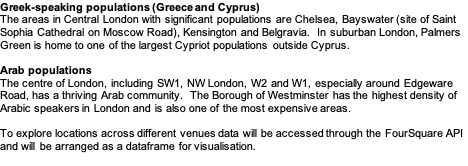